| <font color='red'>Belangrijk!</font> |
|:---|
|Lees voor het maken de inleverinstructies door in de toetsbeschrijving (MS Teams, kanaal algemeen, Files, Moduledocumentatie).  Het niet opvolgen van deze instructies kan leiden tot een onvoldoende |

# Classificatie
Dit werkcollege gaat over classificatie. We hebben gegevens die we in classes willen indelen. Dit kunnen allerlei type klassen zijn. In ons geval gaan we voorspellen of het morgen in Leiden (of eigenlijk Schiphol) gaat regenen. 

De gegevens komen van het KNMI:  https://daggegevens.knmi.nl/klimatologie/daggegevens. Ik heb Schiphol (station 240) gepakt omdat daar gegevens van de laatste 20 jaar beschikbaar waren. 
Vervolgens heb ik de dataset in excel bewerkt:
- De datum is opgesplitst in losse kolommen met YYYY, MM en DD. 
- Op basis van de datum is er een kolom met het meteorologische seizoenen toegevoegd (niet te verwarren met astronomische seizoenen). 
- De lege cellen (waar spaties instonden) vervangen met 'NaN' zodat deze in pandas worden opgepikt als NaN waarde. 
- Op basis van de hoeveelheid regen de dag erna is er 1 kolomm toegvoegd:
  - RM: Regen morgen, gebaseerd op de totale neerslag van de dag erna (kolom RH):
    - Als RH == 0 "False"
    - Als RH <> 0 "True"

Totale dataset:

    FG        : Etmaalgemiddelde windsnelheid (in 0.1 m/s) / Daily mean windspeed (in 0.1 m/s)
    TG        : Etmaalgemiddelde temperatuur (in 0.1 graden Celsius) / Daily mean temperature in (0.1 degrees Celsius)
    TN        : Minimum temperatuur (in 0.1 graden Celsius) / Minimum temperature (in 0.1 degrees Celsius)
    TX        : Maximum temperatuur (in 0.1 graden Celsius) / Maximum temperature (in 0.1 degrees Celsius)
    SP        : Percentage van de langst mogelijke zonneschijnduur / Percentage of maximum potential sunshine duration
    RH        : Etmaalsom van de neerslag (in 0.1 mm) (-1 voor <0.05 mm) / Daily precipitation amount (in 0.1 mm) (-1 for <0.05 mm)
    PG        : Etmaalgemiddelde luchtdruk herleid tot zeeniveau (in 0.1 hPa) berekend uit 24 uurwaarden / Daily mean sea level pressure (in 0.1 hPa) calculated from 24 hourly values
    NG        : Etmaalgemiddelde bewolking (bedekkingsgraad van de bovenlucht in achtsten; 9=bovenlucht onzichtbaar) / Mean daily cloud cover (in octants; 9=sky invisible)
    UG        : Etmaalgemiddelde relatieve vochtigheid (in procenten) / Daily mean relative atmospheric humidity (in percents)
    RM        : Regen morgen, of de dag erna regen meer dan 0mm regen is gevallen

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score

# Data inlezen en voorbereiden
Schrijf de code om de file in te lezen:

In [2]:
pad_naar_file = "knmi_schiphol.csv"

In [3]:
def read_data(csv_file):
    
    dataframe = pd.read_csv(csv_file, sep=';')
    return dataframe

df = read_data(pad_naar_file);

Als je het goed gedaan hebt, is df nu een DataFrame met 7306 rijen en 16 kolommen:

In [4]:
df.shape

(7306, 16)

Als jouw dataframe slechts 1 kolom heeft:
 - open dan de 'knmi_schiphol.csv' in notepad of notepad++ 
 - kijk eens naar de separator die gebruikt is 
 - Ga naar de documentatie van Pandas read_csv (just google it) en check wat je moet veranderen in jouw code

## sneak peak data
Dit hebben we nu zovaak gedaan, dat ik je onderstaande code gratis geef. Zo kun je tijdens het werkcollege focussen op de nieuwe stof. 

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7306 entries, 0 to 7305
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   FG        7306 non-null   int64  
 1   TG        7306 non-null   int64  
 2   TN        7306 non-null   int64  
 3   TX        7306 non-null   int64  
 4   SQ        7306 non-null   int64  
 5   SP        7306 non-null   int64  
 6   RH        7306 non-null   int64  
 7   PG        7306 non-null   int64  
 8   NG        7301 non-null   float64
 9   UG        7306 non-null   int64  
 10  YYYYMMDD  7306 non-null   int64  
 11  YYYY      7306 non-null   int64  
 12  MM        7306 non-null   int64  
 13  DD        7306 non-null   int64  
 14  MS        7306 non-null   object 
 15  RM        7306 non-null   bool   
dtypes: bool(1), float64(1), int64(13), object(1)
memory usage: 863.4+ KB


In [6]:
df.head(5)

,FG,TG,TN,TX,SQ,SP,RH,PG,NG,UG,YYYYMMDD,YYYY,MM,DD,MS,RM
0,45,54,1,88,86,78,-1,10182,5.0,84,20020303,2002,3,3,LENTE,False
1,44,81,71,97,16,15,0,10184,7.0,84,20020304,2002,3,4,LENTE,False
2,40,74,61,101,37,33,0,10131,7.0,83,20020305,2002,3,5,LENTE,True
3,98,84,62,104,0,0,17,10041,7.0,89,20020306,2002,3,6,LENTE,True
4,108,94,69,109,83,74,1,10134,3.0,74,20020307,2002,3,7,LENTE,False


In [7]:
print(df['NG'].unique())
print(df['MS'].unique())
df.isnull().sum(axis = 0) 

[ 5.  7.  3.  6.  4.  8.  2.  1.  0. nan]
['LENTE' 'ZOMER' 'HERFST' 'WINTER']


FG          0
TG          0
TN          0
TX          0
SQ          0
SP          0
RH          0
PG          0
NG          5
UG          0
YYYYMMDD    0
YYYY        0
MM          0
DD          0
MS          0
RM          0
dtype: int64

Checkt of er genoeg samples van de klassen van onze afhankelijke variabele zijn. Zo niet, dan moeten we andere maatregelen nemen. In dit geval zijn de klassen voldoende gelijk verdeeld. 

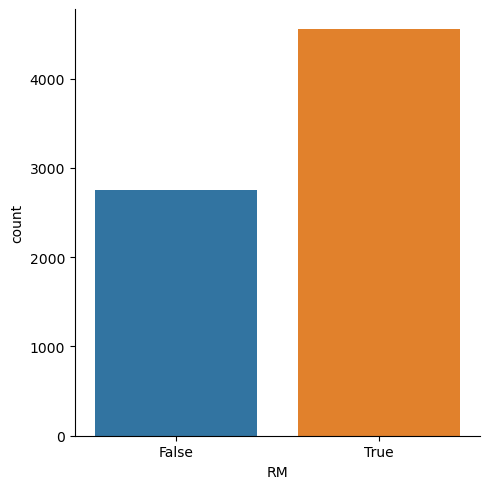

In [8]:
sns.catplot(x='RM', data=df,kind='count')    

## data voorbereiden
Hier verwijder je de NaN en zet de categorienamen om naar nummers:

In [9]:
def data_voorbereiden(dataframe):
    
    #NaN replacement
    #Schrijf je code hier

    #Vervang de seizoenen voor nummers
    set_ms = {'LENTE':0,'ZOMER':1, 'HERFST':2, 'WINTER':3}
    dataframe['MS'] = dataframe['MS'].map(set_ms)


    #omdat deze kolom alleen True False bevat
    dataframe['RM'] = dataframe['RM'].astype(int)

    return dataframe

In [10]:
def verwijder_NaN(dataframe):

    dataframe['NG'].fillna(dataframe['NG'].mode()[0], inplace=True)

    return dataframe

In [11]:
df = data_voorbereiden(df)
df = verwijder_NaN(df)

#### sample data samplen
Als je een pairpliot maakt, heb je misschien gemerkt dat het langzaam gaat. Dat komt omdat seaborn __elk__ punt intekent. Door een sample te nemen van tussen de 500 en 1000 rijen, heb je al een representatief beeld van de verdeling van de data èn gaat het plotten een stuk sneller. In onderstaande code neem ik een sample met het commando ```df.sample(500)```: 

In [12]:
# sns.pairplot(df.sample(500), height=2.5);

Ik maak nu een matplotlib subplot object aan, waar ik de heatmap inzet. Op deze manier schaal ik de heatmap naar 20 bij 15 (experimenteer met de getallen om het effect te zien), zodat het een beetje beter leesbaar is:

In [13]:
plt.subplots(figsize=(20,15))
sns.heatmap(df.corr(), annot = True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm')

<AxesSubplot:>

Op basis van bovenstaand plot verwijder ik:

 - __TN__ en __TX__, die zijn gecorreleerd aan TG. Ik hou liever 1 dan 2 kolommen over
 - __SP__ en __SQ__, die zijn gecorreleerd aan NG. Om 3 redenenen:
    - Ik hou liever 1 dan 2 kolommen over
    - je hebt eerder bewolking (NG) voor regen nodig dan zon (SP, SQ)
    - Er is een hogere correlatie tussen NG en RM vergeleken met de (negatieve) correlatie tussen SP & SQ en RM 
    
 - __YYYYMMDD__ dit is de row identifier. Dus die mag ook weg. 
 

### <font color='red'>Vraag</font> 
Wat vind je van het niet verwijderen van YYYY en DD? Zou jij die laten staan of niet?

Het zegt iets over de data, maar het voegt niet veel toe. Ik zou hem niet laten staan

In [14]:
def verwijder_kolommen(dataframe):
    
    
    dataframe.drop('TN', inplace=True, axis=1)
    dataframe.drop('SP', inplace=True, axis=1)
    dataframe.drop('SQ', inplace=True, axis=1)
    dataframe.drop('YYYYMMDD', inplace=True, axis=1)

    return dataframe

In [15]:
df = verwijder_kolommen(df)

In [16]:
plt.subplots(figsize=(20,15))
sns.heatmap(df.corr(), annot = True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm')

<AxesSubplot:>

## Data splitsen en schalen
Laten we onze data splitsen in onafhankelijke variabelen X en afhankelijke variabele y. 
Onze afhankelijke variabele is Regen Morgen (RM). De uitkomst is binair: 

 0. Nee, het is morgen droog
 1. Ja, het regent morgen

In [17]:
y = df['RM']
X = df.drop(['RM'],axis=1)

Daarna gaan we X en y splitsen in trainingset en testset:

In [18]:
split_test_size = 0.30

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split_test_size, random_state=42)  

## Feature Scaling
We gaan nu onze data schalen. Dit doen we op onze _Trainingsset_. Namelijk onze testset representateert onze onbekende data. Als we deze testset meenemen in de schaling, dan lekken we informatie van onze trainingsdata in de testdata en wordt ons model onbruikbaar. 

Wat we dus doen is het volgende:

 - ```scaler = StandardScaler()``` we maken ons model aan
 - ```trainingsdata = scaler.fit_transform(trainingsdata)```  we fitten onze scalar op de trainingsdata en die transformeren we naar een verdeling met gemiddelde = 0 en standaard deviate is 1. 
 - ```testdata = scaler.transform(testdata)``` nu gaan we onze testdata transformeren op de scalar die gefit is op de trainingsdata. 
 
 
Zoals je ziet, schalen we de afhankelijke variabele niet. Dit komt omdat de uitkomst al tussen de 0 en 1 ligt, of in ieder geval klein genoeg is (er zijn maar een maximaal aantal klassen waarmee we werken). 

Voor regressie hebben we niet geschaald, normaal schalen we dat wel voor de features and the target tussen Min Max : https://stats.stackexchange.com/questions/111467/is-it-necessary-to-scale-the-target-value-in-addition-to-scaling-features-for-re https://stats.stackexchange.com/questions/111467/is-it-necessary-to-scale-the-target-value-in-addition-to-scaling-features-for-re

standaard scaler versus Min-Max scaler..

Vul nu zelf het scaler object.

In [19]:
scaler = StandardScaler()
trainingsdata = scaler.fit_transform(X_train)
testdata = scaler.transform(X_test)
col_names= list(X.columns)
print(col_names)

['FG', 'TG', 'TX', 'RH', 'PG', 'NG', 'UG', 'YYYY', 'MM', 'DD', 'MS']


Schaal nu zelf de data en vergeet niet om de dataset weer om te zetten naar een pandas dataframe (zie werkcollege2)

In [20]:
new_df = pd.DataFrame(scaler.transform(X), columns=col_names)

check of het gelukt is:

In [21]:
X_train.describe()

,FG,TG,TX,RH,PG,NG,UG,YYYY,MM,DD,MS
count,5114.000000,5114.000000,5114.000000,5114.000000,5114.000000,5114.000000,5114.000000,5114.000000,5114.000000,5114.000000,5114.000000
mean,49.062769,109.768088,146.956785,22.731521,10152.988072,5.466758,80.142941,2011.695542,6.493743,15.721744,1.472038
std,21.844269,60.476071,68.728671,46.990647,97.319749,2.332638,9.669590,5.736249,3.422533,8.849029,1.116743
min,9.000000,-77.000000,-40.000000,-1.000000,9729.000000,0.000000,33.000000,2002.000000,1.000000,1.000000,0.000000
25%,33.000000,66.000000,95.000000,0.000000,10095.000000,4.000000,74.000000,2007.000000,4.000000,8.000000,0.000000
50%,45.000000,110.000000,146.000000,1.000000,10159.000000,6.000000,81.000000,2012.000000,7.000000,16.000000,1.000000
75%,61.000000,159.000000,200.000000,25.000000,10217.000000,7.000000,87.000000,2017.000000,9.000000,23.000000,2.000000
max,154.000000,295.000000,364.000000,605.000000,10449.000000,8.000000,100.000000,2022.000000,12.000000,31.000000,3.000000


In [22]:
X_test.describe()

,FG,TG,TX,RH,PG,NG,UG,YYYY,MM,DD,MS
count,2192.000000,2192.000000,2192.000000,2192.000000,2192.000000,2192.000000,2192.000000,2192.000000,2192.000000,2192.000000,2192.00000
mean,48.545164,107.558850,144.263686,22.648723,10152.526004,5.520073,80.520073,2011.606296,6.589416,15.742245,1.53604
std,21.370966,61.330376,70.251077,49.412364,100.419727,2.301659,9.712224,5.880106,3.509684,8.691092,1.11730
min,10.000000,-115.000000,-56.000000,-1.000000,9770.000000,0.000000,40.000000,2002.000000,1.000000,1.000000,0.00000
25%,33.000000,62.000000,90.750000,0.000000,10094.000000,4.000000,74.000000,2006.000000,4.000000,8.000000,1.00000
50%,45.000000,107.000000,145.000000,1.000000,10158.000000,6.000000,82.000000,2012.000000,7.000000,16.000000,2.00000
75%,60.000000,156.000000,197.000000,25.000000,10218.000000,7.000000,88.000000,2017.000000,10.000000,23.000000,3.00000
max,150.000000,267.000000,355.000000,672.000000,10464.000000,8.000000,99.000000,2022.000000,12.000000,31.000000,3.00000


Zoals je ziet heeft de X_train een gemiddelde van 0 en een standaard deviatie van 1. Maar de X_test wijkt daar meer vanaf. Dit komt door de natuurlijke variatie in de dataset. Als dit heel erg afwijkt, heb je misschien een andere verdeling van je train en testdata nodig. Of je zult extra aandacht aan cross-validatie moeten besteden (zie verderop in dit notebook)

## Geheugen opruimen
We verwijderen nu onze originele dataset ```df``` en de voorbereidde dataset ```X``` en ```y```. We doen dit om intern geheugen voor ons notebook te sparen. We hebben die namelijk verder nog hard nodig. Als blijkt dat je geheugen nog steeds niet voldoende leeg is, kun je ervoor kiezen om de plots, zoals sns.heatmap en sns.pairpot in het commentaar te zetten. Die grafische elementen kunnen de boel vertragen:

In [23]:
del X
del y
del df

ps. let op dat je natuurlijk niet de gevraagde variabelen deleted. Want die gebruiken we om jouw werk na te kijken :)


# Classificatie 
We gaan nu een classificatie doen, we gaan de weerparameters indelen in 2 klassen. 
De ene klasse bevat de weerparameters waarbij het de volgende dag gaat regenen: RM == 1
De andere klasse bevat de weerparameters waarbij het droog blijft: RM == 0



## Naive Bayes
De eerste classifier is de Naieve Bayes classifier, die heb je al in actie gezien in werkcollege 1. Je ziet dat deze ook weer volgens hetzelfde stramien werkt:

    model = maakClassiferObject()
    model = model.fit(X_train, y_train)
    resultaat_training = model.predict(X_train)
    accuracy = accuracy_score(y_train, resultaat_training)
    resultaat_test = model.predict(X_train)
    accuracy = accuracy_score(y_train, resultaat_test)
    
Vervolgens een handmatige check of the accuracy van de training en test niet te veel afwijkt en acceptabel zijn. 

In [24]:
nb_model = GaussianNB()


nb_model = nb_model.fit(X_train, y_train)
nb_resultaat_train = nb_model.predict(X_train)
nb_accuracy_train = metrics.accuracy_score(y_train, nb_resultaat_train)
nb_accuracy_train

0.7008212749315604

In [25]:
nb_resultaat_test = nb_model.predict(X_test)
nb_accuracy =  metrics.accuracy_score(y_train, nb_resultaat_train)
nb_accuracy

0.7008212749315604

## Support Vector classifier
Nu mag je hetzelfde doen voor de support vector classifier (SVC() ), gebruik de documentatie om hyperparameters met de juiste waarden in te vullen:
- Gebruik de rbf kernel
- random state moet 5 zijn
- ```probability=True```: Deze parameter is nodig om straks de validatie te doen (meer specifiek om de ROC curves te berekenen, meer hierover later).

In [26]:
svc_model = SVC(kernel='rbf', random_state=5, probability=True)
svc_model.fit(X_train, y_train)

#training data
svc_resultaat_train = svc_model.predict(X_train)
svc_accuracy_train = metrics.accuracy_score(y_train, nb_resultaat_train)
svc_accuracy_train

0.7008212749315604

In [27]:
#test data
svc_resultaat_test = svc_model.predict(X_test)
svc_accuracy = metrics.accuracy_score(y_test, svc_resultaat_test)
svc_accuracy

0.6172445255474452

## Validatie classifiers
Onderstaande vragen kun je beantwoorden aan de hand van de kennisclip validatie. 

We gaan nu de confusion matrix bereken. Hiervoor gebruiken we de functie ```confusion_matrix(werkelijkheid, voorspelling```. Je krijgt dan een 2d array terug, die de confusion matrix bevat. Maar wat betekent dit nu? Daarom een voorbeeld:

Er is een test geweest met een getraind model, welke voor 10 dagen heeft voorspeld of er regen komt (1 = Morgen Regen, 0 = Morgen droog):

    y_voorspelling  = [0,0,0,0,0,1,1,1,1,1]
    y_werkelijkheid = [0,0,0,1,1,0,1,1,1,1]

Daaruit kwam de volgende confusion matrix, dit kun je met de hand narekenen als je wilt:

| x | model zegt Droog | model zegt Regen |
|:---|:--:|--|
het bleef droog | 3 | 1 |
er was Regen | 2 | 4 |

In [28]:
y_voorspelling  = [1,1,1,1,0,0,1,0,0,0]
y_werkelijkheid = [1,1,1,1,1,1,0,0,0,0]
confusion_matrix = metrics.confusion_matrix(y_werkelijkheid,y_voorspelling)
confusion_matrix

array([[3, 1],
       [2, 4]], dtype=int64)

### Naieve Bayes
Bereken nu voor jezelf de confusion matrix voor de naieve bayes:

In [29]:
confusion_matrix_nb = metrics.confusion_matrix(y_test, nb_resultaat_test)
confusion_matrix_nb

array([[587, 252],
       [399, 954]], dtype=int64)

Vul op basis van bovenstaande confusion matrix de onderstaande waarden in:
  
    tp = True Positive (het is voorspeld dat het gaat regenen en dat gebeurt ook)
    fp = False Positive (het is voorspeld dat het gaat regenen en maar het blijft droog)
    tn = True Negative (het is voorspeld dat het droog blijft en dat gebeurt ook)
    fn = False Negative  (het is voorspeld dat het droog blijft, maar het gaat regenen)

In [30]:
tp_nb = 945
fp_nb = 241 
tn_nb = 598
fn_nb = 408

Hoe houdt dit nu verband met de accuracy die je berekend hebt? Nou zo:

In [31]:
accuracy_nb = (tn_nb + tp_nb)/(tn_nb + tp_nb + fp_nb + fn_nb)
accuracy_nb

0.7039233576642335

Bereken nu zelf aan de hand van de videocolleges de false positive rate (FPR) en de true positive rate (TPR) voor de voorspelde data:

In [32]:
FPR_nb = fp_nb/(fp_nb + tn_nb)
FPR_nb

0.2872467222884386

In [33]:
TPR_nb = tp_nb/(tp_nb + fn_nb)
TPR_nb

0.6984478935698448

### Support Vector Machine Classifer
Bereken ook voor jezelf de confusion matrix voor de support vector classifier.


In [34]:
confusion_matrix_svc = metrics.confusion_matrix(y_test,svc_resultaat_test)
confusion_matrix_svc

array([[   0,  839],
       [   0, 1353]], dtype=int64)

Vul op basis van bovenstaande confusion matrix de onderstaande waarden in:

In [35]:
tp_svc = 1353
fp_svc = 839
tn_svc = 0
fn_svc = 0

In [36]:
accuracy_svc = (tn_svc + tp_svc)/(tn_svc + tp_svc + fp_svc + fn_svc)
accuracy_svc

0.6172445255474452

In [37]:
FPR_svc = fp_svc/(fp_svc + tn_svc)
FPR_svc

1.0

In [38]:
TPR_svc = tp_svc/(tp_svc + tn_svc)
TPR_svc

1.0

## ROC curves 
Welke classifier is nu beter? We weten hoe we de volgende waardes te kunnen interpreteren:
- Accuracy zo hoog mogelijk, maar geeft vals beeld als de classes niet gelijk verdeeld zijn. 
- FPR zo laag mogelijk
- TPR zo hoog mogelijk

Maar dan komt er nog steeds niet een eenduidig beeld uit of we Support Vectors of Naieve Bayes als beste model kunnen gebruiken. 

Laten we eens kijken hoe de ROC curve. Om deze te bouwen, moeten we de volgende stappen gebruiken:
 1. We bereken voor elke rij (dus elke dag) de kans dat het in een bepaalde klasse terechtkomt (dus of het regent)
 2. Die kansen leggen we tegen de werkelijkheid om een serie TPRs en FPRs voor ons getrainde model te berkenen, waarmee we de ROC curve kunnen opstellen. (meer details in de kennisclips)
 

### stap 1: kansen per klasse bepalen:
We gebruiken de functie ```predict_proba```, die automatisch voor ons een waardes voor de ROC curve teruggeeft. We hebben dus nu een DataFrame met evenveel rijen als onze X en evenveel kolommen als er klassen zijn:

In [39]:
# Bereken de kans op een voorspelling (als het morgen gaat regenen, hoe groot is de kans dat dit klopt?)
nb_probs = nb_model.predict_proba(X_test)
print(nb_probs.shape)
svc_probs = svc_model.predict_proba(X_test)
print(svc_probs.shape)

(2192, 2)
(2192, 2)


Omdat we dus alleen geinteresseerd zijn of het morgen regent, dus RM = True. Kijken we alleen naar de klasse met het label == 1. We selecteren die kolom dus uit de data:

In [40]:
nb_probs = nb_model.predict_proba(X_test)[:,1]
svc_probs = svc_model.predict_proba(X_test)[:,1]

### stap 2: Serie van TPR en FPR berekenen 
We gebruiken de functie ```roc_curve(werkelijkheid, kansen)```, die automatisch voor ons alle FPR en TPR waardes voor de ROC curve teruggeeft. _ als parameter betekent in python "negeer deze variabele".

De werkelijkheid bevat onze uiteindelijke data en de kansen is voor elk rij de kans dat die rij aan de klasse wordt toegekent:

In [41]:
nb_fpr, nb_tpr, _ = roc_curve(y_test, nb_probs)
svc_fpr, svc_tpr, _ = roc_curve(y_test, svc_probs)

Laten we deze eens plotten in een grafiek:

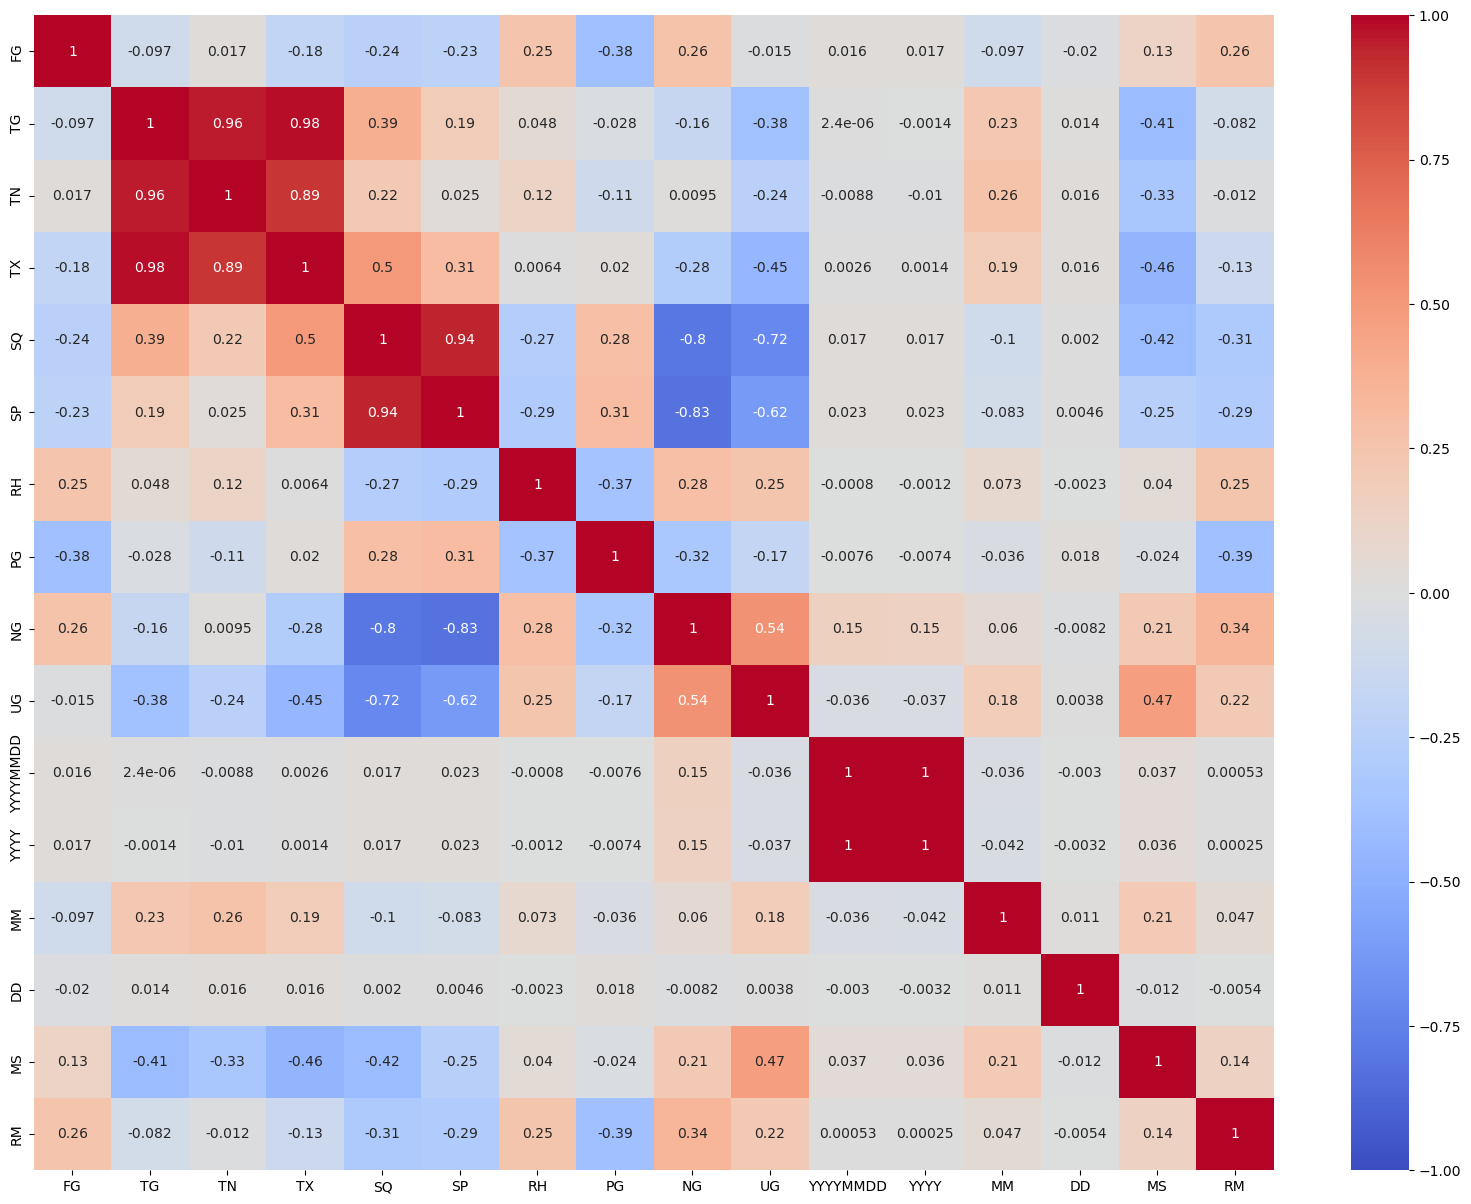

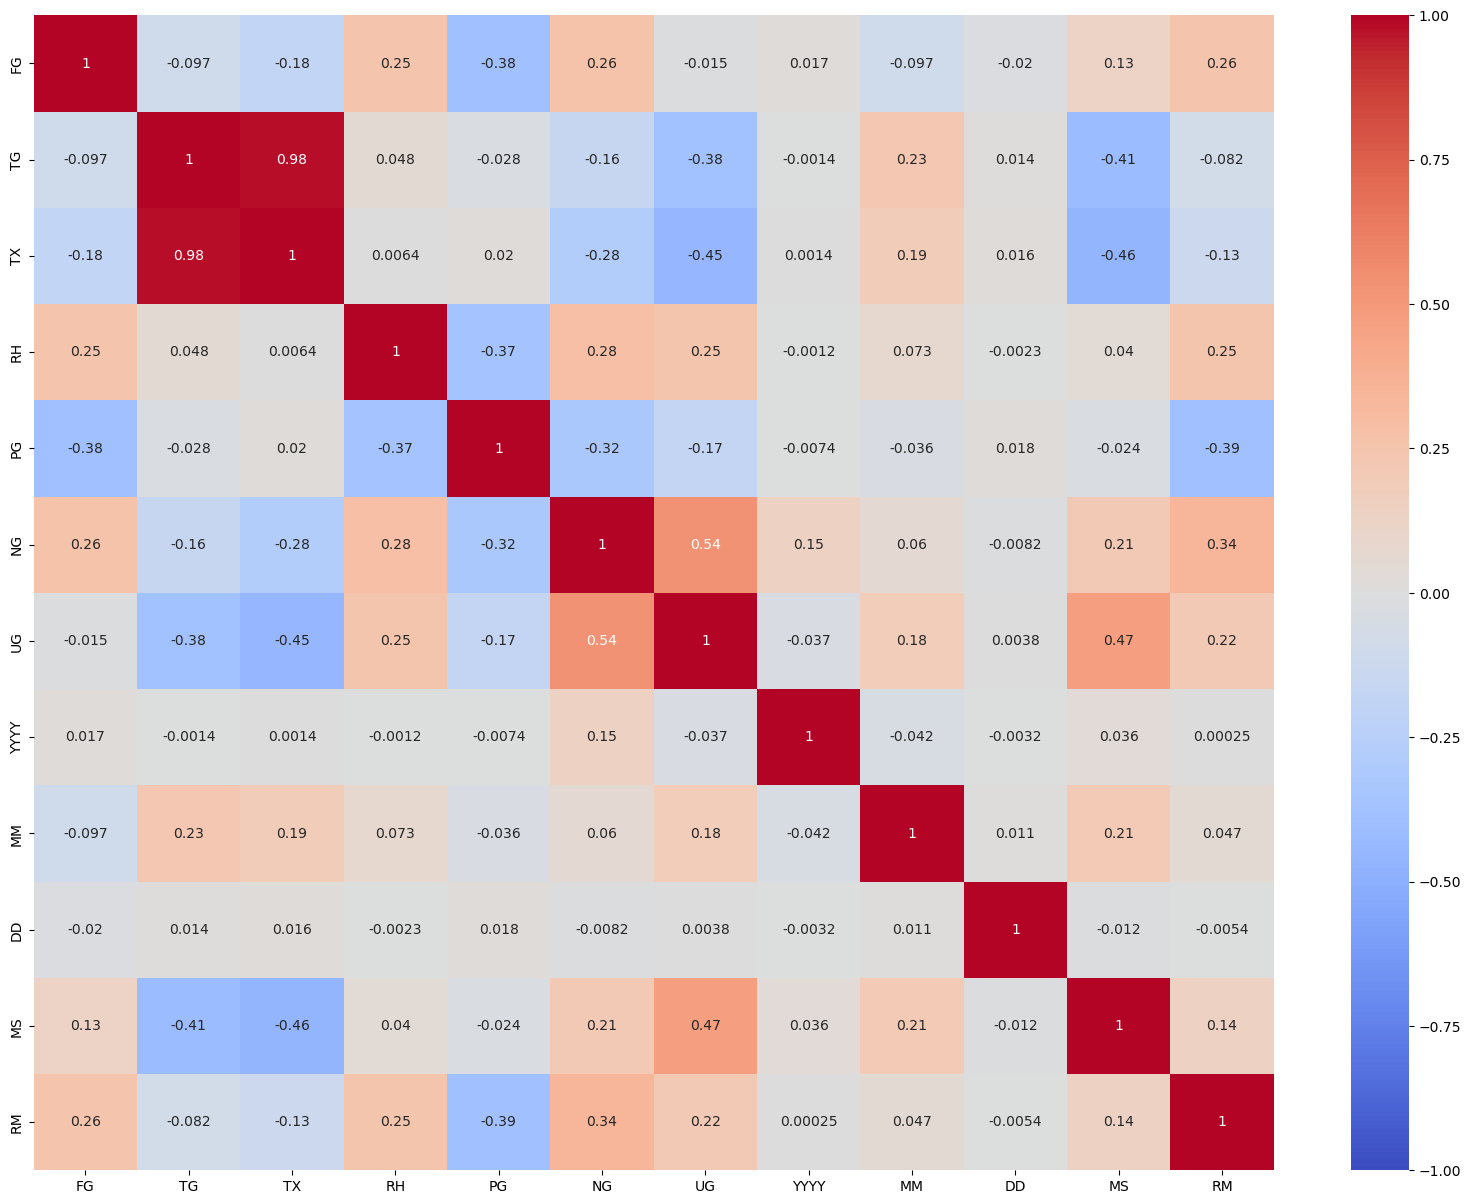

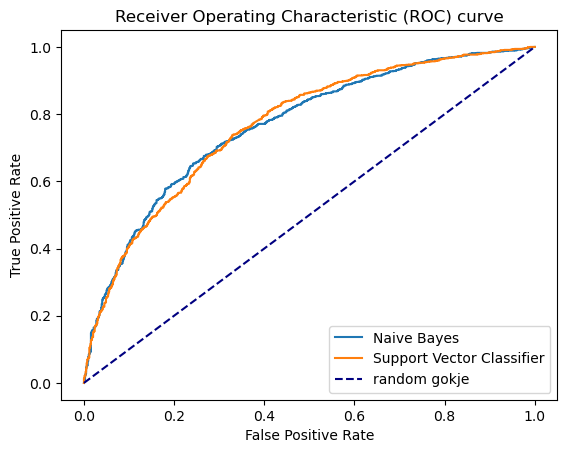

In [42]:
plt.figure()

# plot the roc curve for the model
plt.plot(nb_fpr, nb_tpr,  label='Naive Bayes')
plt.plot(svc_fpr, svc_tpr,  label='Support Vector Classifier')
plt.plot([0, 1], [0, 1], color="navy", linestyle="--", label='random gokje')

#print tekst voor as-labels, titel en legenda
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("Receiver Operating Characteristic (ROC) curve")
plt.legend(loc="lower right")

#laat het plot zien
plt.show()

### <font color='red'>Vraag</font> 
Je ziet dat de classifers erlkaar eigenlijk niet zoveel ontlopen. Welk model zou jij kiezen?

# Cross-Validatie
Je hebt vorige week al in de kennisclips kunnen kennismaken met __cross-validatie__ .  Cross-validatie kun je op 2 manieren gebruiken: 

 1. __Betrouwbaarheid__
    Als er veel variatie in jouw data zit, kun je testen of het model betrouwbaar genoeg is: 
    Heeft het model voor verschillende data, dezelfde accuracy?
 2. __Hyperparameter selectie__
    Als je voor een algoritme verschillende hyperparameters kunt kiezen, hoe weet je dan welke je nodig hebt?

## Betrouwbaarheid

### support vector machine
We gaan een support vector classifier maken, maar zoals je in de documentatie kan lezen, zijn er veel verschillende opties. Hoe kun je nu weten welke de juiste, meest optimale hyperparameters zijn. Daarvoor gebruiken we de __cross-validatie__ waar je al in de kennisclip van 2 weken geleden kennis mee hebt gemaakt. 

Bereken nu de scores voor het ```svc_model``` met 6 folds:

In [43]:
scores_svc = cross_val_score(svc_model, X_test, y_test, cv = 6)
scores_svc

array([0.61748634, 0.61748634, 0.61917808, 0.61643836, 0.61643836,
       0.61643836])

We hebben nu 6 voorspellingen omdat we de data in 6 verschillende stukken hebben opgehakt. 
De belangrijkste waardes voor ons om in de gaten te houden is het gemiddelde van deze score en de standaardeviatie.

Als de standaarddeviate van deze score groot is, zitten er grote afwijkingen in onze dataset en dus is ons model
misschien minder betrouwbaar omdat de voorspellingen kunnen wisselen. 

In [44]:
scores_svc_mean = scores_svc.mean()
scores_svc_std = scores_svc.std()

print(scores_svc_mean)
print(scores_svc_std)

0.6172443047134267
0.0009836425098339336


### Naieve Bayes Classifier
Bereken nu voor Naieve bayes the cross validate op basis van 6 folds.

In [45]:
# Maak de 6-fold cross validatie
scores_nb = cross_val_score(nb_model, X_train, X_train, cv = 6)
scores_nb

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
6 fits failed out of a total of 6.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\naive_bayes.py", line 244, in fit
    y = self._validate_data(y=y)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py", line 569, in _validate_data
    y = _check_y(y, **check_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\skl

array([nan, nan, nan, nan, nan, nan])

In [46]:
scores_nb_mean = scores_nb.mean()
scores_nb_std = scores_nb.std()

print(scores_nb_mean)
print(scores_nb_std)

nan
nan


### <font color='red'>Vraag</font> 
Welke classifier vindt je het meest betrouwbaar? Waarom?

In [47]:
betrouwbaarste_model = nb_model
# omdat het de kleinste standaard deviatie heeft

    <De standard deviation van de Naive Bayes model is een flinke stuk beter dan de Support Vector Machine Classifier, dit betekents dat de gemiddelde voorspellingen meer in de righting liggen om de waardes van de mean dat een model hoort te volgen.>


# Gaat het vandaag regenen?
Gaat het morgen regenen of niet? Ga nu zelf naar de website van het KNMI zoals de link hierboven en haal de gegevens van gisteren op voor het weerstation van Schiphol.

1. Vul ```gekozen_datum``` met de string uit de kolom YYYYMMDD, zodat wij in codegrade kunnen controleren welke dag je gepakt hebt en jouw uitkomst kunnen vergelijken met de weerdata van het KNMI. Zo kun je straks in condegrade controleren of je deze stap goed hebt gedaan.
2. Maak vervolgens zelf een dictionary ```jouwdata``` aan, waarin je de juiste kolommen vult met data uit de knmi website. Vul de missende kolommen zelf aan zoals bovenaan beschreven. 
3. Bewerk ```X_jij``` op de juiste wijze voor zodat het een Pandas DataFrame is, met de juiste kolommen waarin de waarde gestandaardiseerd zijn. De bewerkte gegevens moeten uiteindelijk overeenkomen, met de data, zoals die in ```X_test``` staat (alleen heeft X_jij dan natuurlijk slechts 1 rij).



In [48]:
gekozen_datum = 20020103
jouwdata = {'FG': 58,
            'TG': 50,
            'TN': -1,
            'TX': 103,
            'SQ': 105,
            'SP': 92,
            'RH': 0,
            'PG': 10207,
            'NG': 0,
            'UG': 60,
            'YYYYMMDD': 20220103,
            'YYYY': 2022,
            'MM': 1,
            'DD': 3,
            'MS': 0}

#maakt van de data een Pandas Dataframe:
jouwdata = pd.DataFrame(jouwdata, index=[0])

#print jouw data zodat je kunt zien of het klopt:
jouwdata.head()


,FG,TG,TN,TX,SQ,SP,RH,PG,NG,UG,YYYYMMDD,YYYY,MM,DD,MS
0,58,50,-1,103,105,92,0,10207,0,60,20220103,2022,1,3,0


In [49]:
X_jij = verwijder_kolommen(jouwdata)
X_jij = verwijder_NaN(X_jij)
X_jij = pd.DataFrame(scaler.transform(X_jij), columns=list(X_jij.columns))
X_jij.head()

,FG,TG,TX,RH,PG,NG,UG,YYYY,MM,DD,MS
0,0.409174,-0.98839,-0.639632,-0.483793,0.555049,-2.343824,-2.083326,1.796551,-1.605326,-1.437784,-1.318281


Als de data goed is voorbereid, kun je hieronder uitlezen of je vandaag een paraplu nodig hebt. 

In [50]:
uitslag = {1: "Ja", 0: "nee"}
voorspelling_jij = betrouwbaarste_model.predict(X_jij)[0]
uitslag[voorspelling_jij]

'Ja'

Geef hieronder een float met de kans dat de voorspelling correct is:


In [51]:
accuracy_beste_model = accuracy_svc

Waarom een ja/nee antwoord? We kunnen ook uitrekenen wat de kans is dat het droog blijft en de kans dat het gaat regenen met predict_proba! Kun jij de data interpreteren. Geef de kansen in float in de desbetreffende  variabelen:

In [52]:
st_probs = betrouwbaarste_model.predict_proba(X_jij)
st_probs

array([[0., 1.]])

In [53]:
#Class 0 is droog, class 1 is regen:
kans_regen = 0
kans_droog = 100